<h2>Intro:</h2>

This is the implementation of the Mozgalo task.
Dataset of features is loaded with torchfile library, which knows how to load already extracted features inside xxx.t7 file that contains the results of feature extraction done by [Torch](http://torch.ch/).

[PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is used to reduce the high dimensionality(Torch output is 2048 features per example image), and remove potential linear correlation between features.

As an optimal clustering method it was decided for [GMM](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to be used.


In [1]:
#needed imports

import sklearn
from sklearn import decomposition
import torchfile
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os
from shutil import copyfile
import binascii
from sklearn.mixture import GaussianMixture
import random
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load whole dataset

dataset = torchfile.load('DatasetFeatures.t7')
print (dataset.features.shape)

(6889, 2048)


In [3]:
n_components = 1000 # value decided by trial and error method, gives best results for clustering
pca = decomposition.PCA(n_components=n_components, svd_solver='full')
pca.fit(dataset.features)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [4]:
transformed_data = pca.transform(dataset.features)

<h1>WARNING</h1>

Next cell can only be run after the files in the dataset have been formatted accordingly by the convertImageFormat.py script.

The script needs to be centered next to the original dataset folder and NEEDS to be run <b>before</b> running the Torch feature extraction process.

Run: python convertImageFormat.py 

In [5]:
n_clusters = 10 # value chosen by trial and error method, 10 gives the optimal clusters representation

transformed_data_unshuffled = pca.transform(dataset.features)

for i in range(n_clusters):
    newpath = r'./class_' + str(i)
    if not os.path.exists(newpath):
        os.makedirs(newpath)

clusterer = GaussianMixture(n_components=n_clusters, random_state=12)
clusterer.fit(transformed_data_unshuffled)

for i in range(len(dataset.image_list)):
    path = dataset.image_list[i]
    feature_vec = transformed_data_unshuffled[i]
    class_val = clusterer.predict(feature_vec)
    save_path = r'./class_' + str(class_val[0])
    tokens = path.decode("utf-8").split('/')
    try:
        copyfile(path.decode("utf-8"), save_path + '/' + tokens[len(tokens) - 1])
    except IOError:
        last = tokens[len(tokens) - 1]
        last=last.replace('.jpg', '.png')
        copyfile(path.decode("utf-8").replace('.jpg', '.png'), save_path + '/' + last)
    


For n_clusters = 10 The average silhouette_score is : 0.237253534328


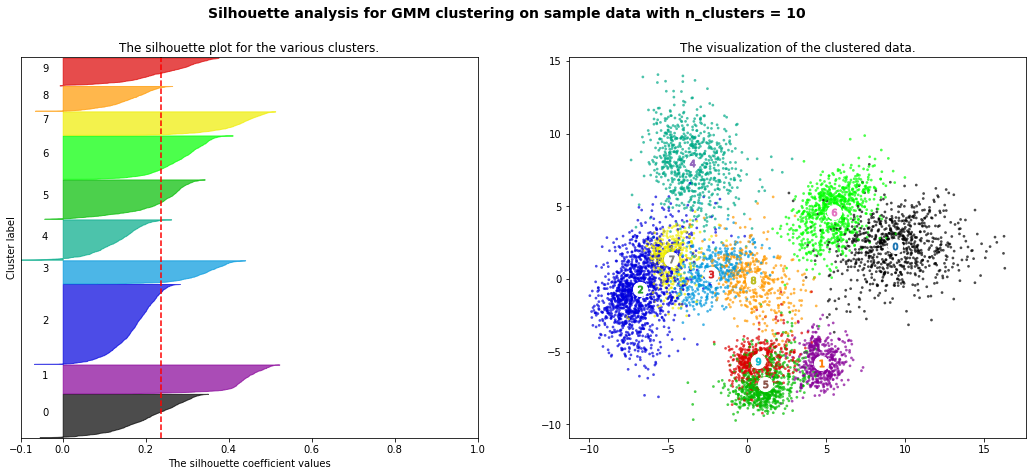

In [6]:
n_clusters = 10


# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(transformed_data) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
#clusterer = GaussianMixture(n_components=n_clusters)
#clusterer.fit(transformed_data)
cluster_labels = clusterer.predict(transformed_data)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(transformed_data, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(transformed_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(transformed_data[:, 0], transformed_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors)

# Labeling the clusters
centers = clusterer.means_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

ax2.set_title("The visualization of the clustered data.")

plt.suptitle(("Silhouette analysis for GMM clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()

<h2>END</h2>

This marks the end of the Mozgalo task.

The code bellow is a tryout code for word embeddings. As you can see, API that was used is not giving expected results for many clusters. While in some clusters it is able to deduce the correct target of the group(group 3 for example), in some clusters the result is a straightforward failure(group 7 for example).

Used API: [NLTK](http://www.nltk.org/) ➡ [Wordnet](https://pythonprogramming.net/wordnet-nltk-tutorial/)



In [14]:

"""
    Calculates n nearest examples for each centroid of the given dataset.
    Returns them for each cluster in a list.
"""
def get_n_nearest_per_centroid(clusterer, n, torch_dataset):
    data_per_class = []
    data = pca.transform(torch_dataset.features)
    image_names = np.asarray(torch_dataset.image_list)
    np.matrix(image_names)
    predictions = clusterer.predict(data)
    data_with_probs = np.c_[image_names, predictions]
    data_with_probs = np.c_[data_with_probs, clusterer.score_samples(data)[:]]
    data_with_probs = sorted(data_with_probs, key=lambda e: e[-1]) 
    
    clusters = set(predictions)
    ct_clusters = len(clusters)

    for cluster in range(ct_clusters):
        indices = np.where(np.array(data_with_probs)[:,1] == str(cluster))
        indices = indices[0]
        data_per_class.append([])
        for i in range(n):
            data_per_class[cluster].append(data_with_probs[indices[i]])
    return data_per_class

#############################################################################
import random

"""
    Simple getter for n random examples for each cluster in given dataset.
    Returns the list of n examples for each cluster.
"""
def get_n_random(clusterer, n, torch_dataset):
    data_per_class = []
    data = pca.transform(torch_dataset.features)
    image_names = np.asarray(torch_dataset.image_list)
    np.matrix(image_names)
    predictions = clusterer.predict(data)
    data_with_predictions = np.c_[image_names, predictions]
    
    clusters = set(predictions)  
    ct_clusters = len(clusters)
    
    for cluster in range(ct_clusters):
        indices = np.where(np.array(data_with_predictions)[:,1] == str(cluster))
        indices = indices[random.randint(0, len(indices)-1)]
        data_per_class.append([])
        for i in range(n):
            data_per_class[cluster].append(data_with_predictions[indices[i]])
    return data_per_class

In [15]:
#nearest = get_n_nearest_per_centroid(clusterer, 15, dataset)
random_representants = get_n_random(clusterer, 10, dataset)

In [16]:
"""
    Parser for input text.
    Text contains the word embeddings that were given by wordnet API for examples.
    Returns the list of embeddings.
"""
def process_torch_output(text):
    word_list = []
    lines = text.split('\n')[1:]
    
    lines = lines[2:len(lines)-2]
    
    for line in lines:
        words = line.split('\t')[1:-1]
        for i in range(len(words)):
            words[i] = words[i].replace(' ', '')
        all_words = []
        for i in range(len(words)):
            for word in words:
                splitted = word.split(',')
                for s in splitted:
                    all_words.append(s)
        for word in all_words:
            word_list.append(word)
    return word_list

In [19]:
import subprocess

cluster_words = {}

for i, cluster_representants in enumerate(random_representants):
    cluster_words[i] = []
    for representant in cluster_representants:
        classifier = '../../resnet/fb.resnet.torch/pretrained/classify.lua'
        resnet = '../../resnet/resnet-200.t7'
        image = representant[0].replace('.jpg', '.png')
        cluster_words[i] = cluster_words[i] + (process_torch_output(subprocess.check_output(['th', classifier, resnet, image])))

In [21]:
import nltk
from nltk import wordnet
nltk.download('wordnet')

wn = wordnet.wordnet

def get_up_to_second_level_hypernyms(word):
    roots = set()
    roots.add(word)
    first_level_roots = set()
    for i,j in enumerate(wn.synsets(word)):
        for hyper in (j.hypernyms()):
            first_level_roots.add(hyper.name().split('.')[0])
    roots.update(first_level_roots)
    for w in first_level_roots:
        for i,j in enumerate(wn.synsets(w)):
            for hyper in (j.hypernyms()):
                roots.add(hyper.name().split('.')[0])
    return roots

from collections import Counter

def get_cluster_descriptor(cluster_words):
    words = []
    for word in cluster_words:
        for w in get_up_to_second_level_hypernyms(word):
            words.append(w)
    return Counter(words)

def get_n_highest(cntr, n):
    best = []
    for i in range(n):
        highest = max(cntr, key=cntr.get)
        best.append(highest)
        del cntr[highest]
    return best

[nltk_data] Downloading package wordnet to /home/nikola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The most possible cluster descriptors are:
--Cluster0 descriptor--
aircraft
mechanism
object
lighter-than-air_craft



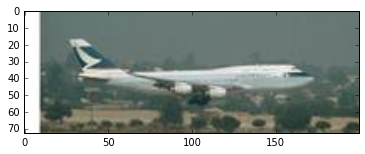

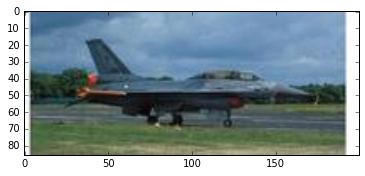

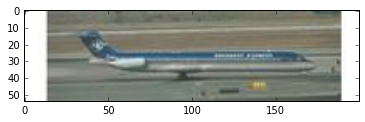

--Cluster1 descriptor--
car
motor_vehicle
wheeled_vehicle
compartment



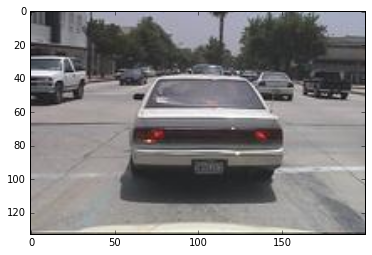

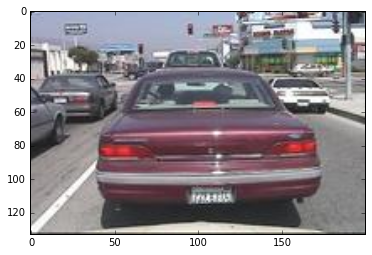

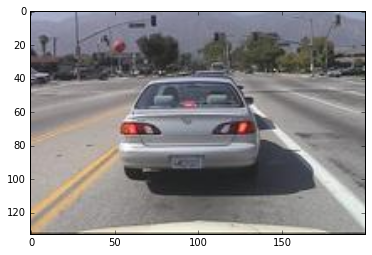

--Cluster2 descriptor--
insect
hymenopterous_insect
change
structure



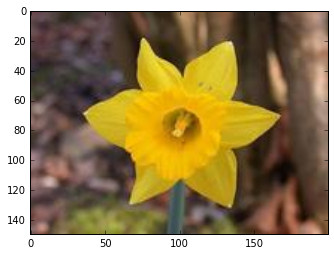

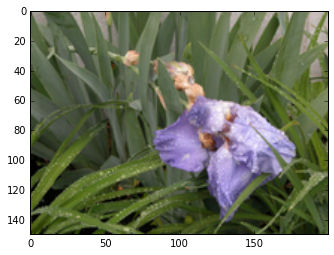

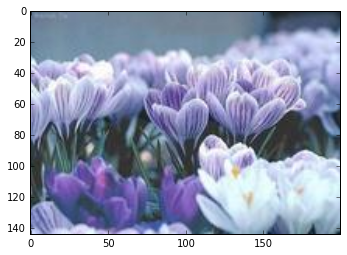

--Cluster3 descriptor--
feline
big_cat
oil_well
attacker



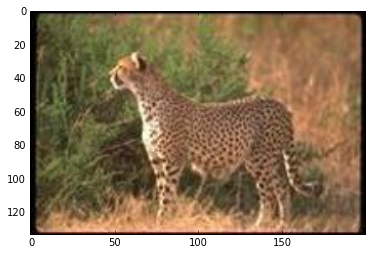

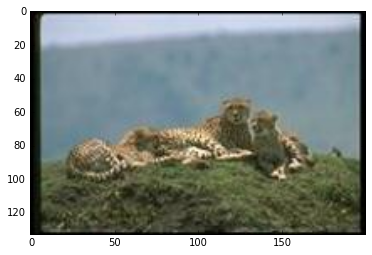

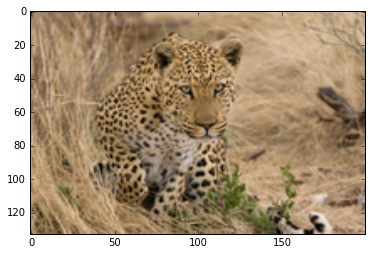

--Cluster4 descriptor--
course
support
shop
obtain



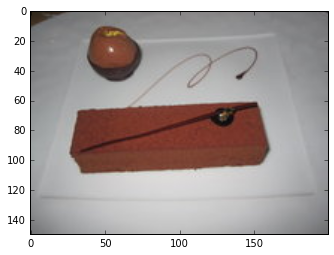

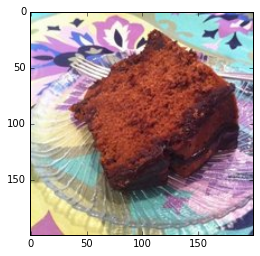

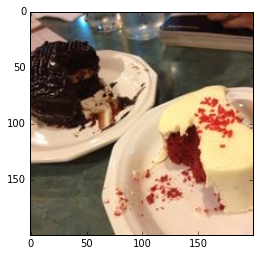

--Cluster5 descriptor--
structure
region
environment
body_part



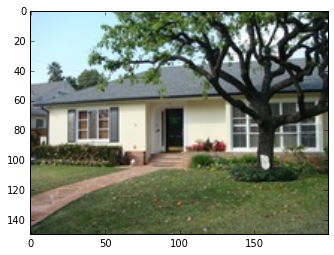

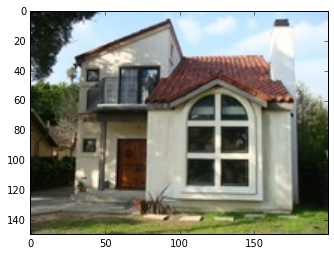

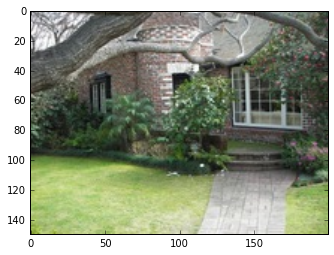

--Cluster6 descriptor--
wheeled_vehicle
container
vehicle
ride



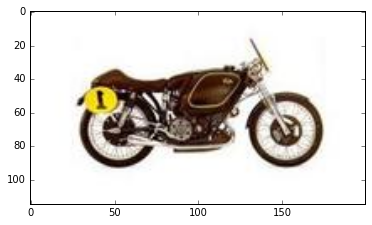

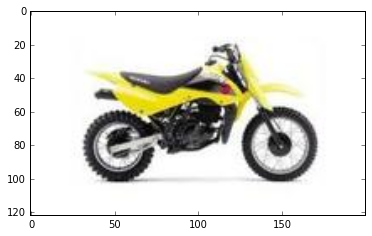

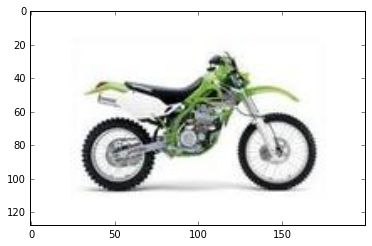

--Cluster7 descriptor--
garment
clothing
food_fish
fish



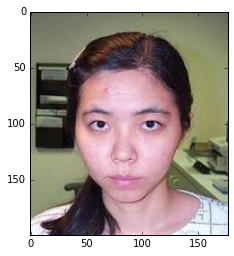

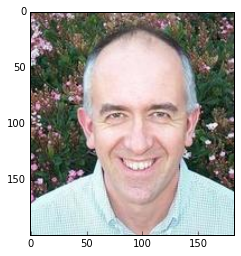

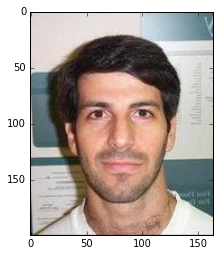

--Cluster8 descriptor--
mountain_sheep
wild_sheep
bovid
RockyMountainbighorn



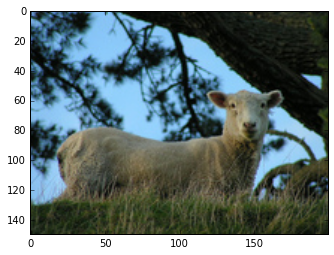

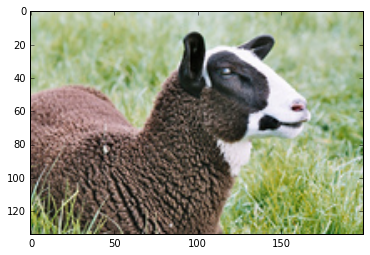

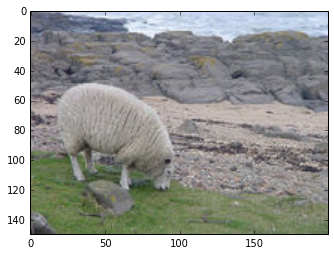

--Cluster9 descriptor--
act
give
wheeled_vehicle
part



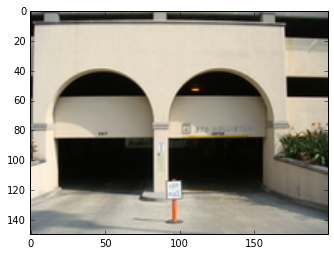

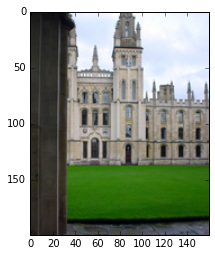

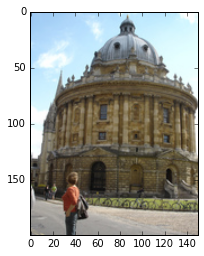

In [32]:
from os import listdir
from os.path import isfile, join
from skimage import data, io
from matplotlib import pyplot as plt
import time

n_cluster_examples = 3
print 'The most possible cluster descriptors are:'
for i in range(10):
    print '--Cluster' + str(i), 'descriptor--'
    cntr = get_cluster_descriptor(cluster_words[i])
    for desc in get_n_highest(cntr, 4):
        print desc
    print
    
    path = r'./class_' + str(i) + '/'
    
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    loaded_images = [io.imread(path + f) for f in onlyfiles[:n_cluster_examples]]
    for ima in loaded_images:
        plt.figure()
        plt.imshow(ima)
        plt.show()
        time.sleep(0.2) # delays for 0.2 seconds because the data rate is exceeded otherwise